# <a id='title'>Оглавление</a>

### [Часть 1. Импорт библиотек / Реализация функций](#import_libs)

###  [Часть 2. Провека и подготовка датасета](#data_prep)
   > [2.1. Импорт данных](#data_prep1)  
   > [2.2. Визуализация данных](#data_prep2)  
   > [2.3. Обработка данных](#data_prep3)  

###  [Часть 3. Обучение модели](#model_train)
   > [3.1. Подбор модели](#model_train1)  
   > [3.2. Подбор гиперпараметров модели](#model_train)  
   > [3.3. Анасамблирование обученных моделей](#model_train3)  

###  [Часть 4. Рассчёт метрик](#model_eval)
   > [3.1. Выбор метрик](#model_eval1)  

## <a id='import_libs'>Часть 1. Импорт библиотек / Реализация функций</a>
[Оглавление](#title)

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек для предобработки данных и моделирования
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import ndcg_score

# Импорт обучающих моделей
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRanker, Pool

# Импорт библиотеки для подбора параметров
import optuna

In [133]:
def ndcg_at_k(y_true, y_score, k):
    # Получим ранги по убыванию оценок
    ranked_indices = np.argsort(y_score)[::-1]
    ranked_y_true = np.take(y_true, ranked_indices)[:k]
    
    # DCG
    dcg = np.sum((2 ** ranked_y_true - 1) / np.log2(np.arange(2, k + 2)))
    
    # Идеальное ранжирования
    ideal_ranked_y_true = np.sort(y_true)[::-1][:k]
    ideal_dcg = np.sum((2 ** ideal_ranked_y_true - 1) / np.log2(np.arange(2, k + 2)))
    
    # NDCG
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    
    return ndcg

In [134]:
def objective(trial):
    weight_model1 = trial.suggest_uniform('weight_model1', 0.0, 1.0)
    weight_model2 = 1.0 - weight_model1  # Вес второй модели будет дополнением до 1
    
    # Получим усредненные предсказания для ансамбля
    y_pred_ensemble = (weight_model1 * y_pred_xgboost) + (weight_model2 * y_pred_catboost)
    
    # NDCG_5
    ndcg_5_ensemble = ndcg_at_k(y_test, y_pred_ensemble, k=5)
    
    return -ndcg_5_ensemble  # Минимизируем отрицательное значение NDCG_5

## <a id='data_prep'>Часть 2. Провека и подготовка датасета</a>
[Оглавление](#title)

#### <a id='data_prep1'>2.1. Импорт данных</a>
[Оглавление](#title)

In [135]:
# Читаем данные с файла и записываем в DataFrame
df = pd.read_csv('intern_task.csv')

In [136]:
# Смотрим на первые 5 строк
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Мы видим достаточно много признаков которые нам необходимо обработать. Чтобы работать с данными дальше, нам необходимо составить о них первое впечатление.  
Таким образом попробуем посмотреть из чего состоит весь наш датафрейм, его размерность, наличие или отсутствие nan-значений.

In [137]:
# Получаем информацию о колонках датафрейма
df.info()

# Мы узнали, что у нас имеется 
# - 140 колонок содержащие тип float64
# - 6 колонок содержащие тип int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB


In [138]:
# Теперь удостоверимся, что мы имеем все данные, и нам не нужно ничего заполнять дополнительно
# df.isna().sum()  -- Так мы сможем получить информацию о каждой из колонок
# Поскольку мы хотим удотсовериться, что у нас ВСЕ значения заполнены, мы можем вызвать .sum() повторно

print('В нашем датафрейме мы имеем {} nan значений'.format(df.isna().sum().sum()))

В нашем датафрейме мы имеем 0 nan значений


In [139]:
# Супер, теперь мы знаем, что отсутствующих значений - нет
# Посмотрим на колл-во строк которые нам доступны

print('В нашем датафрейме {} строк'.format(df.shape[0]))

В нашем датафрейме 235258 строк


#### <a id='data_prep2'>2.2. Визуализация данных</a>
[Оглавление](#title)

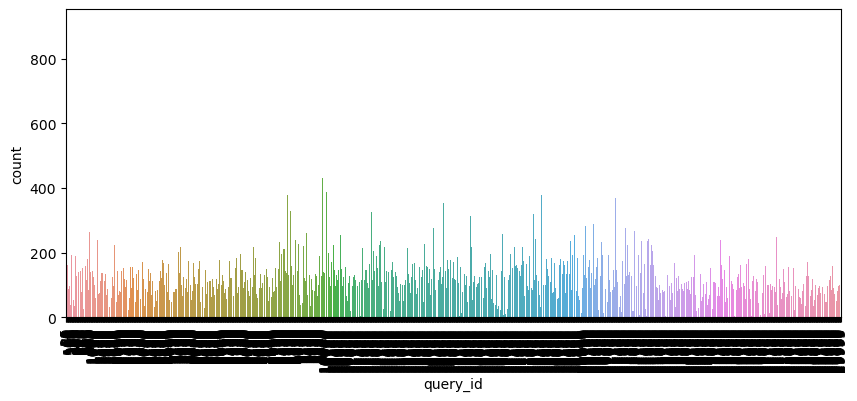

In [140]:
# Построим график, показывающий колл-во упоминаний каждой из сессий

plt.figure(figsize=(10,4))
sns.countplot(data = df, x = 'query_id')
plt.xticks(rotation=90);

Прекрасно! Мы видим огромное колл-во различных сессий пользователей.
Конечно, изначаль можно было предположить, что для нашего датафрейма будет множество различных сессий. Но визуализировав данные, мы удостоверились в этом.

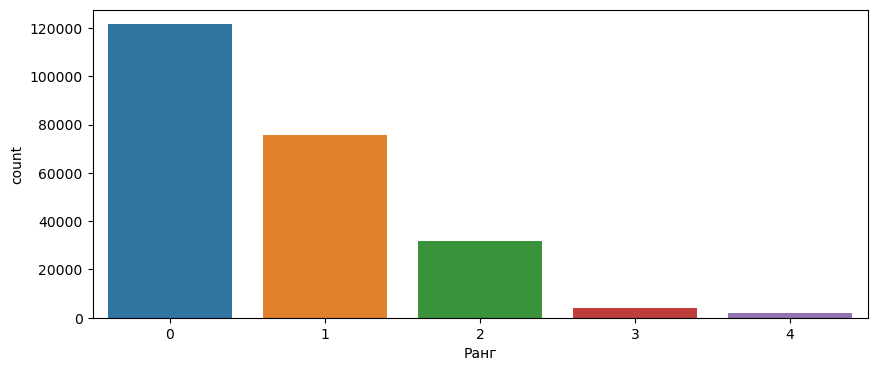

In [141]:
# Аналогичным образом посмотрим на целевую переменную.

plt.figure(figsize=(10,4))
sns.countplot(data = df, x = 'rank')
plt.xlabel('Ранг');

Таким образом, мы видим дисбаланс классов целевой переменной - одни значения ранга встречаются раньше, чем другие. Чтобы решить эту проблему, мы можем уравнять классы, существует несколько подходов для решения проблемы:

- Undersampling - уменьшение колличества образцов часто встречающихся классов
- Oversampling  - увеличение колличества образцов редко встречающихся данных
- *Class Weighting* - со звёздочкой выделим такой подход как class weighting, подход заключается в взвешивании классов во время обучения модели.

Воспользуемся крайним вариантом

#### <a id='data_prep3'>2.3. Обработка данных</a>
[Оглавление](#title)

После поверхностного осмотра имеющихся данных, попробуем проанализировать возможные варианты решения задачи.

Напомню, перед нами стоит задача:
+ натренировать на любом удобном фреймфорке модель, которая будет ранжировать документы по их фичам внутри одной сессии(query_id) (по вектору фичей предсказать ранк документа)

Мы решаем задачу ранжирования - Ранжируем каждый документ по его рангу (релевантности) в рамках конкретной сессии


In [142]:
# Обратим внимание на колонку - query_id. Попробуем рассматривать её как категориаольную переменную
label_encoder = LabelEncoder()
# Применим Label Encoding к столбцу query_id
df['query_id_encoded'] = label_encoder.fit_transform(df['query_id'])
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,query_id_encoded
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333,0
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667,0
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333,0
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667,0
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000,0


In [143]:
# Обратим внимание, на то, что в нашем датафрейме содержится инфмация о более, чем 2000 сессий
df[['query_id', 'query_id_encoded']].drop_duplicates()

,query_id,query_id_encoded
0,10,0
92,25,1
150,40,2
234,55,3
292,70,4
...,...,...
234844,29935,1995
234936,29950,1996
235036,29965,1997
235107,29980,1998


Пермешаем наш датафрейм, чтоб избавиться от структурированности данных, затем разделим наши данные на обучающую и тестовую выборки

In [144]:
X = df.drop(['rank', 'query_id'], axis=1)
y = df['rank'].values
qid = df['query_id'].values

# Перемешаем данные
X, y, qid = shuffle(X, y, qid,random_state = 101)

# Разделим данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test, qid_train, qid_test  = train_test_split(X, y, qid, test_size = 0.2,
                                                          random_state = 101)

# Преобразуем DataFrame в массив NumPy
X_train = X_train.values
X_test = X_test.values

# Отсортируем обучающие данные по идентификаторам
indx = np.argsort(qid_train)
qid_train = qid_train[indx]
y_train = y_train[indx]
X_train = X_train[indx]

# Отсортируем тестовые данные по идентификаторам
indx_test = np.argsort(qid_test)
qid_test = qid_test[indx_test]
y_test = y_test[indx_test]
X_test = X_test[indx_test]

In [145]:
# Теперь, используем StandartScaler, для масштабирования признаков

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Ранее мы добавили в DataFrame новую фичу, нам нужно понять: \
*"Сколько в нашем df - фичей? Все ли из приведённых фичей будут сильно влиять на исследуемую модель? Можем ли мы уменьшить пространство фичей?"*

In [146]:
# Первым делом выведем инфомацию о кол-ве колонок:

print('В нашем датафрейме {} различных фичей'.format(df.shape[1] - 1))

В нашем датафрейме 146 различных фичей


<Axes: >

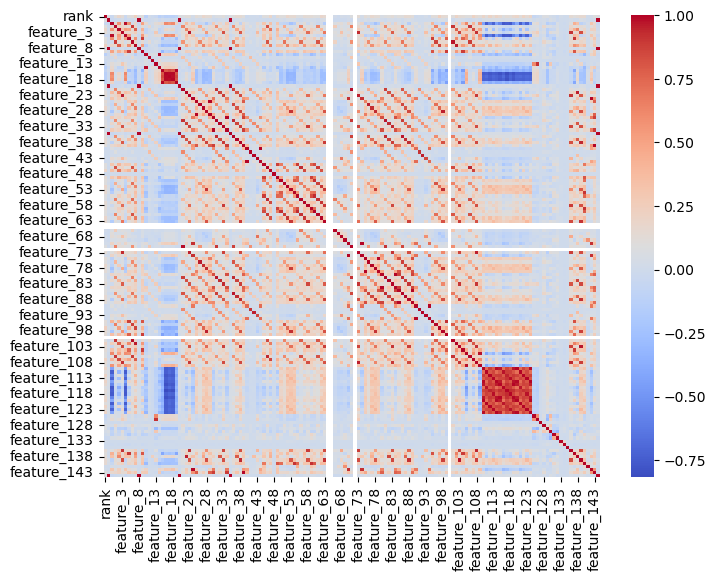

In [147]:
# Посмотрим на матрицу корреляций для нашего датафрейма

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),cmap='coolwarm')

146 - большое кол-во фичей. Все ли они имеют большую корреляцию для целевой перменной? Попробуем уменьшить размерность, для этого применим метод PCA

In [148]:
pca = PCA(n_components = 35)  # Выбираем 35 компонент
pca_X_train = pca.fit_transform(scaled_X_train)
X_train = pca_X_train.copy()

print("Доля объясненной дисперсии для каждой компоненты:")
print(pca.explained_variance_ratio_)

# Применяем получившиесся значения для тестовой выборки
pca_X_test = pca.transform(scaled_X_test)
X_test = pca_X_test.copy()

Доля объясненной дисперсии для каждой компоненты:
[0.17807293 0.12706298 0.07735666 0.07555588 0.05902794 0.03818475
 0.03443058 0.03002007 0.02820109 0.02518632 0.02486274 0.02284961
 0.01978269 0.01780935 0.01398541 0.01327899 0.0128734  0.01152672
 0.01092354 0.01029326 0.00872444 0.00845728 0.00769415 0.0074539
 0.0071311  0.0070921  0.00707499 0.0066165  0.00650304 0.00599461
 0.00586746 0.00565166 0.0055855  0.00539967 0.00502791]


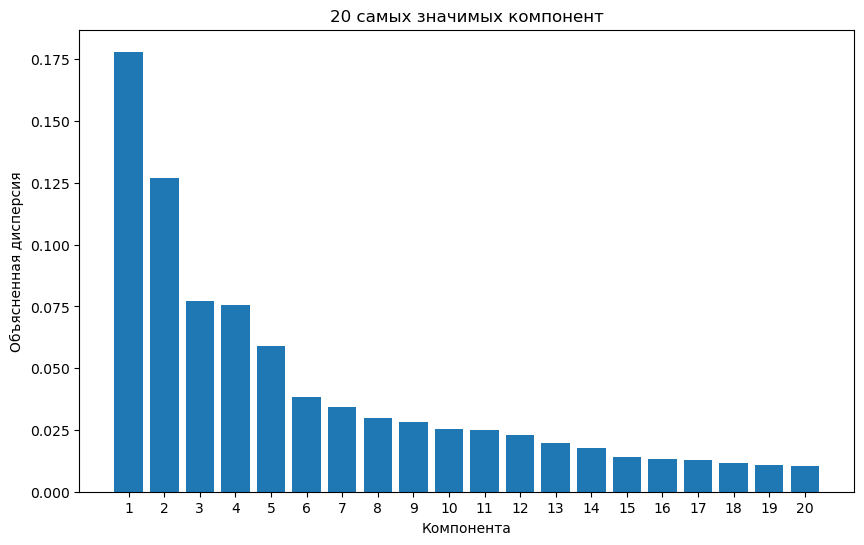

In [149]:
explained_variance_ratio = pca.explained_variance_ratio_

# Получим индексы 20 компонент с наибольшей объясненной дисперсией
top_20_components = explained_variance_ratio.argsort()[::-1][:20]
top_20_variance = explained_variance_ratio[top_20_components]

# Построим график
plt.figure(figsize=(10, 6))
plt.bar(range(1, 21), top_20_variance)
plt.xlabel('Компонента')
plt.ylabel('Объясненная дисперсия')
plt.title('20 самых значимых компонент')
plt.xticks(range(1, 21));

Супер! Теперь, приступим к обучению нашей модели

## <a id='model_train'>Часть 3. Обучение модели</a>
[Оглавление](#title)

#### <a id='model_train1'>3.1. Подбор модели</a>
[Оглавление](#title)

Для решения поставленной задачи, применим следующие алгоритмы обучения
> + XGBRanker  
> + CatBoostRanker  

#### <a id='model_train2'>3.2. Подбор гиперпараметров модели</a>
[Оглавление](#title)

Вспомним о имеющемся дисбалансе классов

In [150]:
# Вычисление долей классов в обучающем наборе данных
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)

# Создание словаря с весами для каждого класса
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [173]:
np.random.seed(101)

# Модель
ranker = xgb.XGBRanker(tree_method = "hist", 
                       lambdarank_num_pair_per_sample = 8,
                       objective = "rank:ndcg",
                       lambdarank_pair_method = "topk",
                       scale_pos_weight=class_weights_dict,
                       random_state = 101)

# Гипрепараметры для перебора
param_dist = {
    'n_estimators': np.random.randint(100, 500, 10),  # Выбор из диапазона от 100 до 500
    'learning_rate': [0.01, 0.05, 0.1, 0.3],          # Скорость обучения
    'max_depth': np.random.randint(3, 15, 10),        # Выбор из диапазона от 3 до 15
    'subsample': [0.6, 0.7, 0.8, 0.9],                # Доля подвыборки для построения каждого дерева
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],         # Доля признаков для построения каждого дерева
    'gamma': [0, 0.1, 0.2, 0.3],                      # Минимальное снижение потерь, необходимое для разбиения узла
    'min_child_weight': np.random.randint(1, 5, 10),  # Выбор из диапазона от 1 до 5
}


random_search = RandomizedSearchCV(estimator = ranker,
                                   param_distributions = param_dist,
                                   n_iter = 50,
                                   cv = 3,
                                   verbose = 2,
                                   scoring = 'neg_mean_squared_error',
                                   n_jobs = -1)


random_search.fit(X_train, y_train, qid=qid_train)

print()

# Приведём наилучшие гиперпараметры
print("Наилучшие гиперпараметры:", random_search.best_params_)

# Получим предсказания на тестовых данных с использованием лучших гиперпараметров
y_pred = random_search.predict(X_test)
y_pred_xgboost = y_pred

# Оценим качество модели с помощью NDCG@5
ndcg_5 = ndcg_at_k(y_test, y_pred, k=5)
print("NDCG_5 на тестовых данных:", ndcg_5)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



Наилучшие гиперпараметры: {'subsample': 0.6, 'n_estimators': 140, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}
NDCG_5 на тестовых данных: 0.32543074207625544


In [174]:
# Веса для каждого объекта
sample_weights = np.ones_like(y_train)  # инициализируем веса единицами
for class_label, weight in class_weights_dict.items():
    sample_weights[y_train == class_label] = weight  # присваиваем объектам вес в соответствии с их классом

# Создадим датасет CatBoost
train_pool = Pool(X_train, y_train, group_id=qid_train, weight=sample_weights)

In [ ]:
np.random.seed(101)

# Модель
ranker_catboost = CatBoostRanker(objective="YetiRank", 
                                 eval_metric='NDCG',
                                 random_state=101)

# Гиперпараметры для перебора
param_grid_catboost = {
    'iterations': [100, 200, 300],        # Количество итераций (деревьев)
    'learning_rate': [0.01, 0.05, 0.1],   # Скорость обучения
    'depth': [3, 6, 9],                   # Максимальная глубина деревьев
    'l2_leaf_reg': [1, 3, 5],             # L2 регуляризация
}

# Обучение модели с помощью валидации CatBoost
grid_search_catboost = ranker_catboost.grid_search(param_grid_catboost,
                                                   train_pool,
                                                   cv=3,
                                                   # verbose=2,   # Можно наблюдать за процессом обучения модели
                                                   plot=True)

# Приведём наилучшие гиперпараметры
print("Наилучшие гиперпараметры для CatBoost:", grid_search_catboost['params'])

# Получим предсказания на тестовых данных с использованием лучших гиперпараметров
y_pred_catboost = ranker_catboost.predict(X_test)

# Оценим качество модели с помощью NDCG@5
ndcg_5_catboost = ndcg_at_k(y_test, y_pred_catboost, k=5)
print("NDCG_5 на тестовых данных для CatBoost:", ndcg_5_catboost)

In [192]:
print("Наилучшие гиперпараметры для CatBoost:", grid_search_catboost['params'])

print("NDCG_5 на тестовых данных для CatBoost:", ndcg_5_catboost)

Наилучшие гиперпараметры для CatBoost: {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 300}
NDCG_5 на тестовых данных для CatBoost: 0.3810721607728556


#### <a id='model_train3'>3.3. Анасамблирование обученных моделей</a>
[Оглавление](#title)

Мы видим что у обученныех моделей разная точность, замечу что результаты, хоть и различные, все же не должны быть игнорированы. Возможно, недостаточный уровень точности связан с неподходящим выбором гиперпараметров.

Для формирования итогового результата воспользуемся ансаблированием моделей

In [178]:
# Усредняем результаты моделей
y_pred_ensemble = (y_pred_xgboost + y_pred_catboost) / 2

# Оценим результат ансамбля
ndcg_5_ensemble = ndcg_at_k(y_test, y_pred_ensemble, k=5)
print("NDCG_5 на тестовых данных для ансамбля:", ndcg_5_ensemble)

NDCG_5 на тестовых данных для ансамбля: 0.3460841401028978


Мы видим, что при усреднении моделей точность ансамбля низкая. Повысим точность добавив веса для каждой из моделей

In [179]:
weight_model1 = 0.7  # Вес для первой модели
weight_model2 = 0.3  # Вес для второй модели
y_pred_ensemble = (weight_model1 * y_pred_xgboost) + (weight_model2 * y_pred_catboost)

# Оценим результат ансамбля
ndcg_5_ensemble = ndcg_at_k(y_test, y_pred_ensemble, k=5)
print("NDCG_5 на тестовых данных для ансамбля:", ndcg_5_ensemble)

NDCG_5 на тестовых данных для ансамбля: 0.2779189101763015


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Получение оптимальных весов
optimal_weight_model1 = study.best_params['weight_model1']
optimal_weight_model2 = 1.0 - optimal_weight_model1

In [181]:
# Тогда, самая высокая точность будет получена, при
y_pred_ensemble = (optimal_weight_model1 * y_pred_xgboost) + (optimal_weight_model2 * y_pred_catboost)

# Оценим результат ансамбля
ndcg_5_ensemble = ndcg_at_k(y_test, y_pred_ensemble, k=5)
print("NDCG_5 на тестовых данных для ансамбля:", ndcg_5_ensemble)

NDCG_5 на тестовых данных для ансамбля: 0.3810721607728556


## <a id='model_eval'>Часть 4. Рассчёт метрик</a>
[Оглавление](#title)

Помимо приведённой выше метрики NDCG_5, так же рассчитаем метрики 
- NDCG_3
- MAP

In [191]:
ndcg_3 = ndcg_at_k(y_test, y_pred_ensemble, k=3)
ndcg_5 = ndcg_at_k(y_test, y_pred_ensemble, k=5)

print("Полученные метрики")
print("NDCG_3:", ndcg_3)
print("NDCG_5:", ndcg_5)

Полученные метрики
NDCG_3: 0.3482339022803206
NDCG_5: 0.3810721607728556
